<a href="https://colab.research.google.com/github/mukkatharun/DeepLearningAssignments/blob/main/Assignment4/hyperparameters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import math
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


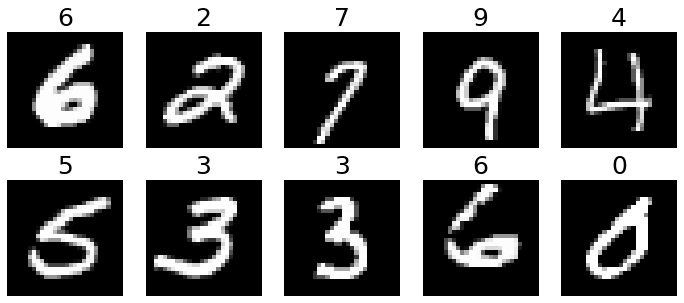

In [3]:
fig, axes = plt.subplots(2,5, figsize=(12,5))
axes = axes.flatten()
idx = np.random.randint(0,42000,size=10)
for i in range(10):
    axes[i].imshow(x_train[idx[i],:].reshape(28,28), cmap='gray')
    axes[i].axis('off') # hide the axes ticks
    axes[i].set_title(str(int(y_train[idx[i]])), color= 'black', fontsize=25)
plt.show()

**Data_Augmentation(To Prevent Overfitting)**

In [4]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


#datagen.fit(x_train)
train_augmentation = datagen.flow(x_train.reshape(-1,28,28,1), y=y_train)

batch_index = 0
x_list, y_list = [], []
while batch_index <= train_augmentation.batch_index:
    data = train_augmentation.next()
    x_list.append(data[0])
    y_list.append(data[1])
    batch_index = batch_index + 1
x_augmentation = np.asarray(x_list).reshape(-1,28, 28)
y_augmentation = np.asarray(y_list).reshape(-1, )

Normalization and One hot encoding of Categorical Data

In [5]:
#images, labels = (x_train[0:1000].reshape(1000,28*28) / 255, y_train[0:1000])
def hot_labels(labels):
  one_hot_labels = np.zeros((len(labels),10))
  for i,l in enumerate(labels):
      one_hot_labels[i][l] = 1
  return one_hot_labels


images, labels = (x_augmentation[0:60000].reshape(60000,28*28) / 255, y_augmentation[0:60000])
labels = hot_labels(labels)
x, y_true = images, labels

test_images = x_test.reshape(len(x_test),28*28) / 255
test_labels = y_test
#test_labels = np.zeros((len(y_test),10))
test_labels = hot_labels(test_labels)
x_test, y_test = test_images, test_labels
print(f'images: {images.shape}, labels: {labels.shape}, test_images: {test_images.shape}, test_labels: {test_labels.shape}')

images: (60000, 784), labels: (60000, 10), test_images: (10000, 784), test_labels: (10000, 10)


**Build Model(RELU,MSE Loss Function)**

In [6]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int =1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2./ input_dim)
    self.bias = np.zeros(num_hidden)

  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis = 0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

class Relu:
  def __call__(self, input_, dropout_rate =0):
    if dropout_rate > 0:
      dropout_mask = np.random.binomial(1, 1-dropout_rate, size=input_.shape)
      input_ *= dropout_mask*2
    self.input_ = input_
    self.output = np.clip(self.input_, 0, None)
    return self.output

  def backward(self, output_gradient):
    self.input_gradient = (self.input_ >0) * output_gradient
    return self.input_gradient

class Model:
  def __init__(self, input_dim, num_hidden, output_dim):
    self.linear1 = Linear(input_dim, num_hidden)
    self.relu1 = Relu()
    self.relu2 = Relu()
    self.linear2 = Linear(num_hidden, output_dim)

  def __call__(self,x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1, dropout_rate=0)
    r2 = self.relu2(r1, dropout_rate=0.01)
    l2 = self.linear2(r2)
    return l2

  def backward(self, output_gradient):
    linear2_grad = self.linear2.backward(output_gradient)
    relu2_grad = self.relu2.backward(linear2_grad)
    relu1_grad = self.relu1.backward(relu2_grad)
    linear1_grad = self.linear1.backward(relu1_grad)
    return linear1_grad


  def update(self, lr):
    self.linear2.update(lr)
    self.linear1.update(lr)

In [7]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient

In [8]:
loss = MSE()
nonlinear = Model(784, 200, 10)

**Mini_Batch_Gradient_Descent**

In [9]:
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

In [10]:
from typing import Callable

def fit_by_batch(x: np.ndarray, y: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, model: Callable, loss: Callable, num_epochs: int, batch_size: int):
  for epoch in range(num_epochs):
    correct_cnt = 0
    lr = lr_decay(epoch/100)
    for i in range(int(len(x) / batch_size)):
      batch_start, batch_end = ((i * batch_size), ((i+1)*batch_size))
      x_batch = x[batch_start: batch_end]
      y_batch = y[batch_start: batch_end]
      y_pred_batch = model(x_batch)
      loss_value = loss(y_pred_batch, y_batch)
      gradient_from_loss = loss.backward()
      model.backward(gradient_from_loss)
      model.update(lr)
      for k in range(batch_size):
        correct_cnt += int(np.argmax(y_pred_batch[k:k+1]) == np.argmax(y_batch[k:k+1]))

    if epoch % 100 == 0:
      test_correct_cnt = 0
      y_pred_test = model(x_test)
      for k in range(len(y_test)):
        test_correct_cnt += int(np.argmax(y_pred_test[k:k+1]) == np.argmax(y_test[k:k+1]))
      print(f'Epoch {epoch}, lr {lr}, loss {loss_value}, correct_rate {correct_cnt/float(len(y))}, test_correct_rate {test_correct_cnt/float(len(y_test))}')

**Training the model using mini batch (Batch_Size=32)**

In [11]:
fit_by_batch(x, y_true, x_test, y_test, model=nonlinear, loss=loss, num_epochs=1000, batch_size=32)

Epoch 0, lr 0.01, loss 0.03917964186393277, correct_rate 0.6340666666666667, test_correct_rate 0.8294
Epoch 100, lr 0.006, loss 0.01082350935468709, correct_rate 0.9569166666666666, test_correct_rate 0.9622
Epoch 200, lr 0.0036, loss 0.008381047971593966, correct_rate 0.9658166666666667, test_correct_rate 0.9643
Epoch 300, lr 0.0021599999999999996, loss 0.007991335251202849, correct_rate 0.9687333333333333, test_correct_rate 0.9648
Epoch 400, lr 0.001296, loss 0.00732870361890349, correct_rate 0.9706166666666667, test_correct_rate 0.9653
Epoch 500, lr 0.0007775999999999998, loss 0.00938152884291422, correct_rate 0.9713166666666667, test_correct_rate 0.9643
Epoch 600, lr 0.0004665599999999999, loss 0.007843177317419122, correct_rate 0.9718333333333333, test_correct_rate 0.9635
Epoch 700, lr 0.00027993599999999994, loss 0.006894618455130022, correct_rate 0.9723, test_correct_rate 0.9658
Epoch 800, lr 0.00016796159999999993, loss 0.007238638451944732, correct_rate 0.9726833333333333, test

**Evaluate the Model Using Confusion Matrix**

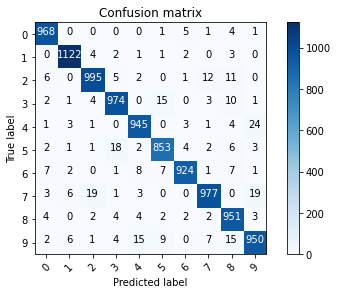

In [12]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = nonlinear(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

**Display_Errors**

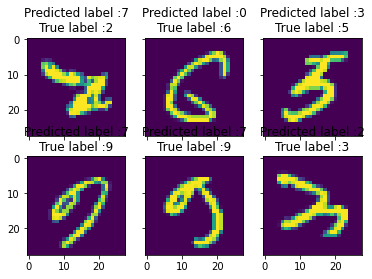

In [13]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_test[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)